In [19]:
# Cubic only. x^3

In [20]:
pip install pyqsp

Note: you may need to restart the kernel to use updated packages.


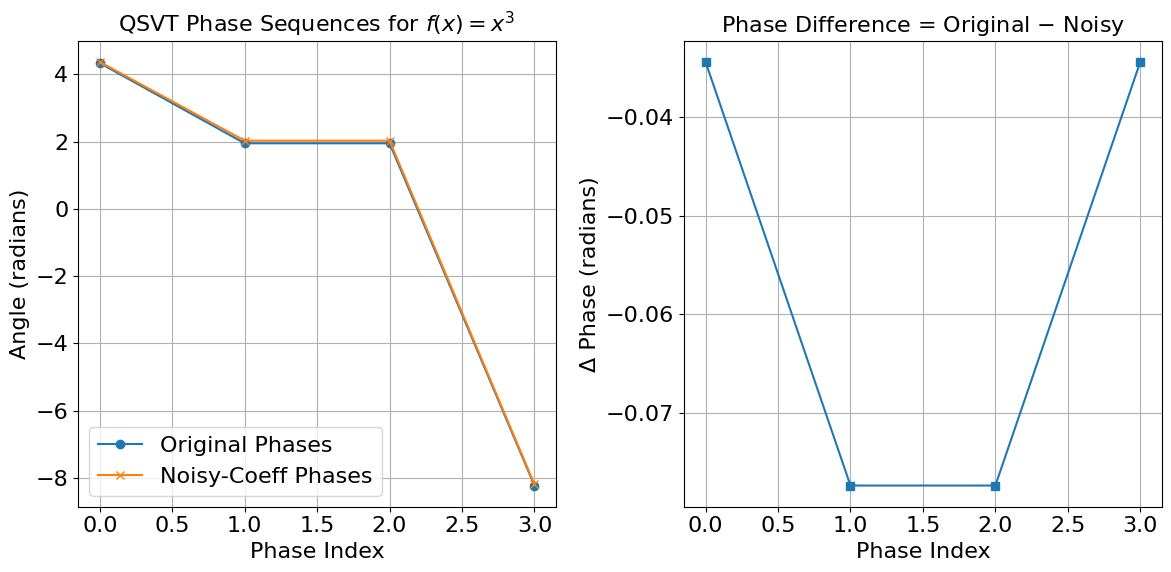

Original coeffs: [0.   0.75 0.   0.25]
Noisy coeffs:    [0.         0.75304717 0.         0.23960016]
Max |Δphase|: 0.07739093771636218
Original_phase [ 4.33972479  1.95346106  1.95346106 -8.22664582]
noisy_phase [ 4.37407968  2.030852    2.030852   -8.19229093]


In [22]:
# --- imports
import numpy as np
import matplotlib.pyplot as plt
from pyqsp.angle_sequence import QuantumSignalProcessingPhases

# --- helper: convert QSP phases (R(x)) to QSVT (W(x)) convention
def adjust_phases(ang_seq):
    phases = np.array(ang_seq, dtype=float)
    N = len(phases)
    phases[1:-1] = phases[1:-1] - np.pi / 2
    phases[0] = phases[0] - np.pi / 4
    phases[-1] = phases[-1] + (2 * (N - 1) - 1) * np.pi / 4
    return -2 * phases  # sign due to exp(-i*phi*Z) convention

# --- x^3 Chebyshev coefficients: x^3 = (T3 + 3*T1)/4
coeffs = np.array([0.0, 0.75, 0.0, 0.25], dtype=float)

# add noise ONLY to odd-indexed coefficients (1, 3) – as requested
def add_noise_to_coeffs(c, idxs=(1, 3), noise_scale=1e-2, seed=None, kind="gaussian"):
    rng = np.random.default_rng(seed)
    noisy = c.copy()
    if kind == "gaussian":
        deltas = rng.normal(0.0, noise_scale, size=len(idxs))
    elif kind == "uniform":
        # symmetric uniform with std ~= noise_scale
        half_range = np.sqrt(3) * noise_scale
        deltas = rng.uniform(-half_range, half_range, size=len(idxs))
    else:
        raise ValueError("kind must be 'gaussian' or 'uniform'")
    for i, di in zip(idxs, deltas):
        noisy[i] += di
    return noisy

# --- make a noisy version of the cubic coefficients
noise_scale = 1e-2
noise_scale_str = format(noise_scale, ".0e")
seed = 42
seed_str = str(seed)
noisy_coeffs = add_noise_to_coeffs(coeffs, idxs=(1, 3), noise_scale=noise_scale, seed=seed, kind="gaussian")

# --- QSP phase synthesis (Laurent approach for signal operator W_x)
ang_seq_orig = QuantumSignalProcessingPhases(coeffs,        signal_operator="Wx", method="laurent", measurement="x")
ang_seq_noisy = QuantumSignalProcessingPhases(noisy_coeffs, signal_operator="Wx", method="laurent", measurement="x")

# --- convert to QSVT phase convention
phases_orig = adjust_phases(ang_seq_orig)
phases_noisy = adjust_phases(ang_seq_noisy)

# --- difference
diff = phases_orig - phases_noisy

# --- plotting
plt.figure(figsize=(12, 6))

font_size = 16
plt.rcParams.update({'font.size': font_size})

plt.subplot(1, 2, 1)
plt.plot(phases_orig, label="Original Phases", marker='o')
plt.plot(phases_noisy, label="Noisy-Coeff Phases", marker='x')
plt.title("QSVT Phase Sequences for $f(x)=x^3$", fontsize=font_size)
plt.xlabel("Phase Index")
plt.ylabel("Angle (radians)")
plt.legend(loc="lower left")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(diff, label="Phase Difference", marker='s')
plt.title("Phase Difference = Original $-$ Noisy", fontsize=font_size)
plt.xlabel("Phase Index")
plt.ylabel("Δ Phase (radians)")
plt.grid(True)

plt.tight_layout()

plt.savefig('figures/func_x_cubed_noise_scale_' + noise_scale_str + '.pdf')

plt.show()

# --- quick diagnostics
print("Original coeffs:", coeffs)
print("Noisy coeffs:   ", noisy_coeffs)
print("Max |Δphase|:", np.max(np.abs(diff)))
print("Original_phase", phases_orig)
print("noisy_phase", phases_noisy)
